In [316]:
import numpy as np
from emnist import extract_training_samples, extract_test_samples

# Ваш whitelist символов
whitelist = 'ABCEHKMOPTXy0123456789'

# Список всех классов в EMNIST
emnist_classes = (
    "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    "abcdefghijklmnopqrstuvwxyz"
)


# Функция для фильтрации данных по whitelist
def filter_data(X, y, whitelist, emnist_classes):
    """
    Фильтрует данные на основе whitelist символов.
    """
    # Создаём словарь для быстрого сопоставления: символ -> индекс в whitelist
    whitelist_mapping = {char: idx for idx, char in enumerate(whitelist)}
    print(whitelist_mapping)
    print(len(y))
    # Создаём список индексов, которые соответствуют whitelist
    filtered_indices = [
        i for i, label in enumerate(y) if emnist_classes[label] in whitelist_mapping
    ]
    print(len(filtered_indices))
    # Отфильтрованные данные
    X_filtered = X[filtered_indices]
    y_filtered = np.array([whitelist_mapping[emnist_classes[label]] for label in y[filtered_indices]])
    print(len(X_filtered))
    print(len(y_filtered))
    return X_filtered, y_filtered

# Загрузка данных из подмножества 'byclass'
X_train_byclass, y_train_byclass = extract_training_samples('byclass')
X_test_byclass, y_test_byclass = extract_test_samples('byclass')
print(y_test_byclass[0])
# Фильтрация данных
X_train, y_train = filter_data(X_train_byclass, y_train_byclass, whitelist, emnist_classes)
X_test, y_test = filter_data(X_test_byclass, y_test_byclass, whitelist, emnist_classes)

# Проверка размеров наборов данных
print(f"Размер обучающего набора: {X_train.shape}, Метки: {y_train.shape}")
print(f"Размер тестового набора: {X_test.shape}, Метки: {y_test.shape}")


18
{'A': 0, 'B': 1, 'C': 2, 'E': 3, 'H': 4, 'K': 5, 'M': 6, 'O': 7, 'P': 8, 'T': 9, 'X': 10, 'y': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21}
697932
433256
433256
433256
{'A': 0, 'B': 1, 'C': 2, 'E': 3, 'H': 4, 'K': 5, 'M': 6, 'O': 7, 'P': 8, 'T': 9, 'X': 10, 'y': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21}
116323
72548
72548
72548
Размер обучающего набора: (433256, 28, 28), Метки: (433256,)
Размер тестового набора: (72548, 28, 28), Метки: (72548,)


In [317]:
class EMNISTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Добавляем канал
        self.y = torch.tensor(y, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Нормализация данных
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # Нормализация в диапазон [-1, 1]
])

# Создание датасетов
train_dataset = EMNISTDataset(X_train, y_train, transform=transform)
test_dataset = EMNISTDataset(X_test, y_test, transform=transform)

# DataLoader для обучения и тестирования
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [318]:
import torch.nn as nn
import torch.nn.functional as F

def compute_output_size(input_size, kernel_size, stride, padding):
        return (input_size - kernel_size + 2 * padding) // stride + 1

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Вычисляем размеры после сверточных слоев
        height = compute_output_size(28, kernel_size=3, stride=1, padding=1)  # conv1
        height = compute_output_size(height, kernel_size=3, stride=1, padding=1)  # conv2
        height = compute_output_size(height, kernel_size=2, stride=2, padding=0)  # pool
        width = height  # Для квадратного входа

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * height * width, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    



# Инициализация модели
num_classes = len(whitelist)
model = CNN(num_classes)


In [319]:
import torch.optim as optim

# Устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

from tqdm import tqdm
import torch

# Цикл обучения с tqdm
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    loop = tqdm(loader, desc="Обучение", leave=False)  # Прогресс-бар для обучения
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход и обновление весов
        loss.backward()
        optimizer.step()

        # Логирование
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        # Обновление tqdm
        loop.set_postfix(loss=loss.item())

    accuracy = 100 * correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

# Цикл оценки с tqdm
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    loop = tqdm(loader, desc="Оценка", leave=False)  # Прогресс-бар для оценки
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Логирование
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Обновление tqdm
            loop.set_postfix(loss=loss.item())

    accuracy = 100 * correct / len(loader.dataset)
    return total_loss / len(loader), accuracy





In [320]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [321]:
# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    
    # Обучение
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # Оценка
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Эпоха 1/10


  Train Loss: 0.4385, Train Accuracy: 86.80%


  Test Loss: 0.1677, Test Accuracy: 93.46%
Эпоха 2/10


  Train Loss: 0.2405, Train Accuracy: 91.25%


  Test Loss: 0.1499, Test Accuracy: 93.91%
Эпоха 3/10


  Train Loss: 0.2105, Train Accuracy: 92.21%


  Test Loss: 0.1608, Test Accuracy: 93.23%
Эпоха 4/10


  Train Loss: 0.1978, Train Accuracy: 92.65%


  Test Loss: 0.1394, Test Accuracy: 94.31%
Эпоха 5/10


  Train Loss: 0.1887, Train Accuracy: 92.92%


  Test Loss: 0.1417, Test Accuracy: 94.46%
Эпоха 6/10


  Train Loss: 0.1841, Train Accuracy: 93.05%


  Test Loss: 0.1473, Test Accuracy: 94.38%
Эпоха 7/10


  Train Loss: 0.1794, Train Accuracy: 93.18%


  Test Loss: 0.1418, Test Accuracy: 94.52%
Эпоха 8/10


  Train Loss: 0.1759, Train Accuracy: 93.30%


  Test Loss: 0.1432, Test Accuracy: 94.42%
Эпоха 9/10


  Train Loss: 0.1728, Train Accuracy: 93.41%


  Test Loss: 0.1406, Test Accuracy: 94.53%
Эпоха 10/10


  Train Loss: 0.1710, Train Accuracy: 93.46%


  Test Loss: 0.1397, Test Accuracy: 94.47%


In [322]:
torch.save(model.state_dict(), "letter_recognition_model1.pth")


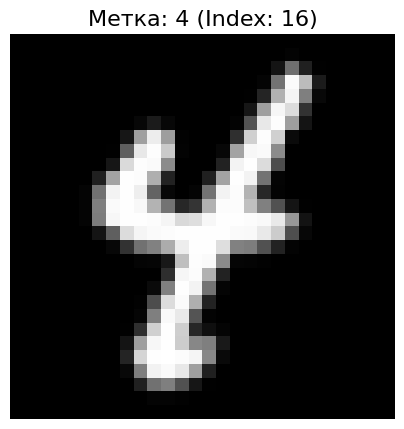

In [337]:
import matplotlib.pyplot as plt
import random

def visualize_test_sample(X_test, y_test, index, whitelist):
    """
    Визуализация тестового примера с его меткой.
    
    :param X_test: Тензор с тестовыми изображениями.
    :param y_test: Тензор с метками тестовых изображений.
    :param index: Индекс примера для отображения.
    :param whitelist: Список символов для сопоставления меток.
    """
    image = X_test[index]  # Убираем канал и переводим в numpy
    label_idx = y_test[index].item()  # Получаем индекс метки
    label_char = whitelist[label_idx]  # Соответствующий символ из whitelist

    # Отображение изображения с меткой
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title(f"Метка: {label_char} (Index: {label_idx})", fontsize=16)
    plt.axis('off')
    plt.show()


# Пример вызова
visualize_test_sample(X_test, y_test, index=random.choice([i for i in range(len(X_test))]), whitelist=whitelist)


In [216]:
len(X_test_all[2])

10000